In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.transforms import Affine2D
from mpl_toolkits.mplot3d import Axes3D

import healpy as hp
from astropy.io import ascii
from astropy import constants as const

from astropy.io import fits
from astropy.table import Table, unique

from scipy.integrate import quad



In [4]:
# loading galaxy catalog

gal_file = fits.open('void_flatmock_5.fits') 
data_gal = Table(gal_file[1].data)
z, ra, dec = data_gal['z'], data_gal['ra'], data_gal['dec']
z, dec, ra = np.array(z), np.array(dec), np.array(ra)

#loading void catalog (detected voids, output of voidfinder)

data_vd = ascii.read('void_flatmock_5_maximal_noFiltering.txt', names=['x', 'y', 'z', 'radius', 'flag', 'r', 'ra', 'dec'])
radius_vd,r_vd,ra_vd,dec_vd = data_vd['radius'], data_vd['r'], data_vd['ra'], data_vd['dec']

# loading mock void catalog (injected voids)

data_void = np.load('void_pos_5.npz')
theta2 = data_void['theta'].flatten()
radius2 = data_void['rad'].flatten()
z2 = data_void['z'].flatten()
phi2 = data_void['phi'].flatten()

data_vd = np.array(data_vd)
voids = []
for i in range(0,len(data_vd)):
    if not(data_vd[i][6] > 96 or data_vd[i][6] <86 \
           or data_vd[i][7] > 6 or data_vd[i][7] < -6):
           voids.append(data_vd[i])
voids = np.array(voids)
r1, ra1, dec1, radius1 = [], [], [], []
for i in range(len(voids)):
    r1.append(voids[i][5])
    ra1.append(voids[i][6])
    dec1.append(voids[i][7])
    radius1.append(voids[i][3])
    
r1, ra1, dec1, radius1 = np.array(r1), np.array(ra1), np.array(dec1), np.array(radius1)

In [5]:
# converting redshift z to distance r, takes some time
def Distance(z,omega_m,h):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist
def f(a,omega_m):
    return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))
c = 299792
r = Distance(z,0.3,1)
r_void = Distance(z2,0.3,1)

In [6]:
# following matplolib demo : https://matplotlib.org/xkcd/examples/axes_grid/demo_floating_axes.html 

def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr = tr_rotate + mpl.projections.PolarAxes.PolarTransform()
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra_min, ra_max, cz_min, cz_max))

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    ax1.axis['right'].set_axis_direction('top')
    ax1.axis['bottom'].set_visible(False)
    ax1.axis['top'].set_axis_direction("bottom")

    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("r [Mpc h$^{-1}$]")
    ax1.axis["top"].label.set_text(r"$\alpha_{1950}$")
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax    



'purple-ish are overlapping [almost all], red are injected but not detected [edges], blue sky are detected \n but not injected [almost non existent] '

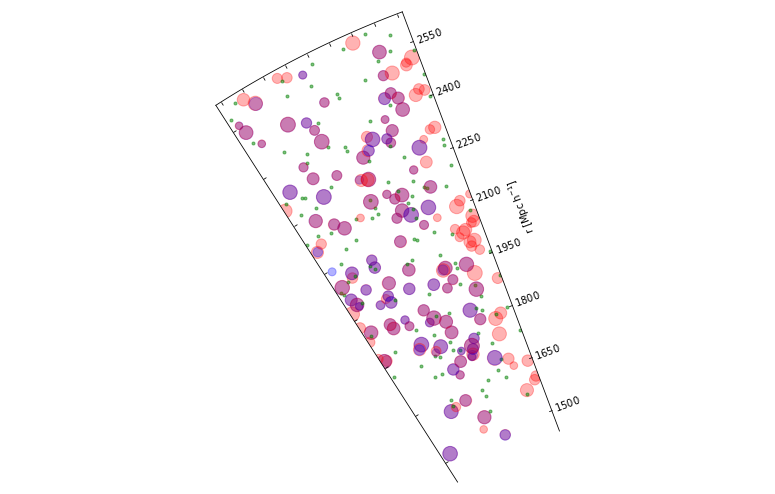

In [24]:
# 'd' is declination and 's' is the thickness of the declination slice, vary 'd' and 's' to get difference slices.
i,d,s = 1,1,0.0002  
fig = plt.figure(1, figsize=(30, 30))
deg = np.pi / 180

cut1 = np.logical_and(r > 2400, r <= 2500)
r_new = r[cut1]

phi = ra*deg # deg-rad conversion

ra_min, ra_max = np.min(phi)-0.5*np.pi, np.max(phi)-0.5*np.pi

c = const.c.to('km/s').value
cz_min, cz_max = np.min(r), np.max(r)

slice_= (d+s)/2  # slice center, can use this for analysis since the slice thickness is very small.

cut = np.logical_and(dec > d, dec <= d+s) 
fig = plt.figure(1, figsize=(30, 30))

this_ra_min, this_ra_max = np.min(phi[cut])-0.5*np.pi, np.max(phi[cut])-0.5*np.pi
rect = 320 + (i+1)
ax, aux_ax = setup_axes3(fig, rect, ra_min, ra_max, cz_min, cz_max)
aux_ax.scatter(phi[cut]-0.5*np.pi, r[cut], color='g' , marker  = '.', alpha=0.5)


# for voids found by voidfinder

dec_intersect = dec1[np.abs(np.array(slice_-dec1))*radius1 <= radius1]  # dec of voids that intersect the slice
radius_intersect = radius1[np.abs(np.array(slice_-dec1))*radius1 <= radius1]
dec_circle = dec1 + np.abs(np.array(slice_-dec1))
ra_circle = ra1[np.abs(np.array(slice_-dec1))*radius1 <= radius1]
r_circle = r1[np.abs(np.array(slice_-dec1))*radius1 <= radius1]
rad_circle = np.sqrt(radius_intersect**2 - (dec_intersect)**2)
phi_circle = ra_circle*deg -0.5*np.pi


# mock voids 

ra2 = 90 - phi2
dec2 = theta2
ra2_circle = ra2[np.abs(np.array(slice_-dec2))*radius2 <= radius2]

dec2_intersect = dec2[np.abs(np.array(slice_-dec2))*radius2 <= radius2]

radius2_intersect = radius2[np.abs(np.array(slice_-dec2))*radius2 <= radius2]

dec2_circle = dec2 + np.abs(np.array(slice_-dec2))

r2_circle = r_void[np.abs(np.array(slice_-dec2))*radius2 <= radius2]

rad2_circle = np.sqrt(radius2_intersect**2 - (dec2_intersect)**2)

phi2_circle = ra2_circle*deg -0.5*np.pi


def pol2cart(rho, phi): # phi = ra and dec = pi/2 - theta
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
x = pol2cart(r_circle,np.array(ra_circle)*deg+0.148*np.pi)[0]  
y = pol2cart(r_circle,np.array(ra_circle)*deg+0.148*np.pi)[1]
''' 0.148 in the expression of x and y is arbitrary but yields the right answer 
   since it was found by alligning the cicles from pol2cart with the matplolib scatter function 
   (except that this latter does not yield the right circle area.)'''

for i in range(len(rad_circle)):
    circle = plt.Circle((np.array(x)[i],np.array(y)[i]), rad_circle[i],transform=ax.transData._b, color = 'b',alpha=0.3)
    aux_ax.add_artist(circle)

#for voids from void catalogue

x2 = pol2cart(r2_circle,np.array(ra2_circle)*deg+0.148*np.pi)[0]
y2 = pol2cart(r2_circle,np.array(ra2_circle)*deg+0.148*np.pi)[1]

#plotting mock voids for comparison

for i in range(len(rad2_circle)):
    circle2 = plt.Circle((np.array(x2)[i],np.array(y2)[i]), rad2_circle[i],transform=ax.transData._b, color="red", alpha=0.3)
    aux_ax.add_artist(circle2)
    
'''purple-ish are overlapping [almost all], red are injected but not detected [edges], blue sky are detected 
 but not injected [almost non existent] '''